Setup

In [173]:
import emcee
from tqdm import tqdm
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functions
from IPython.display import display, Math
import scipy

In [174]:
global H_0, m_0, c
m_0 = -20.45
c = 299792458 # m/s
H_0 = 70*10**-3 #m s^-1 pc^-1

In [175]:
#reads data and saves it into relevantly named variables.
data = functions.read_data('sn_data_extended.txt')
name, redshift, distance_modulus, dm_err = data[0], data[1], data[2], data[3]

#setting some parameters for the resulting plots.
plt.rcParams.update({'font.size': 14, 'lines.markersize': 3})

#defining x and y values and the y errors for the MCMC fitting.
xval = redshift
yval = distance_modulus
yerr = dm_err

#MCMC settings
no_steps = 1000 #2500
no_to_discard = 400 #500

parameter_list = []

*WITHOUT PRIORS*

$\Lambda CDM$ model

100%|██████████| 1000/1000 [14:11<00:00,  1.17it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

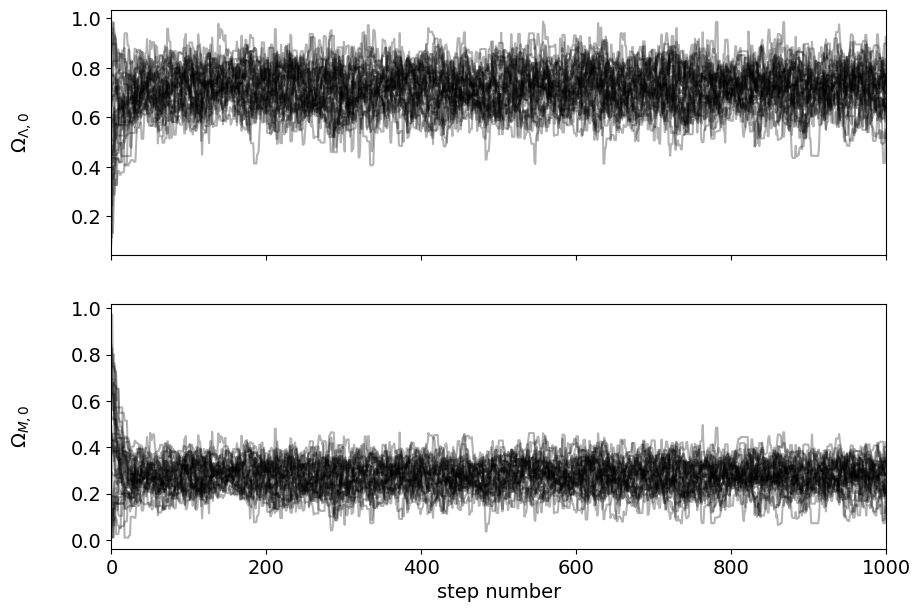

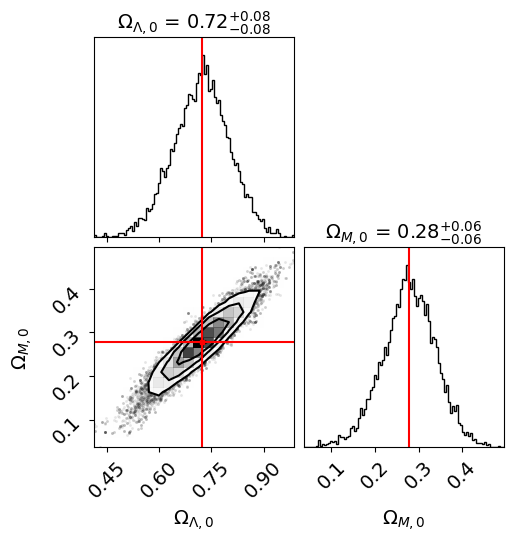

In [176]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0 = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = -1))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0 = theta
    if 0 < omega_lambda0 < 1 and 0 < omega_M0 < 1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, 1]) * np.random.uniform(low=0, high=1, size=(32, 2))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 14})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9727105948134447 
 P-value: 0.6731232774380698


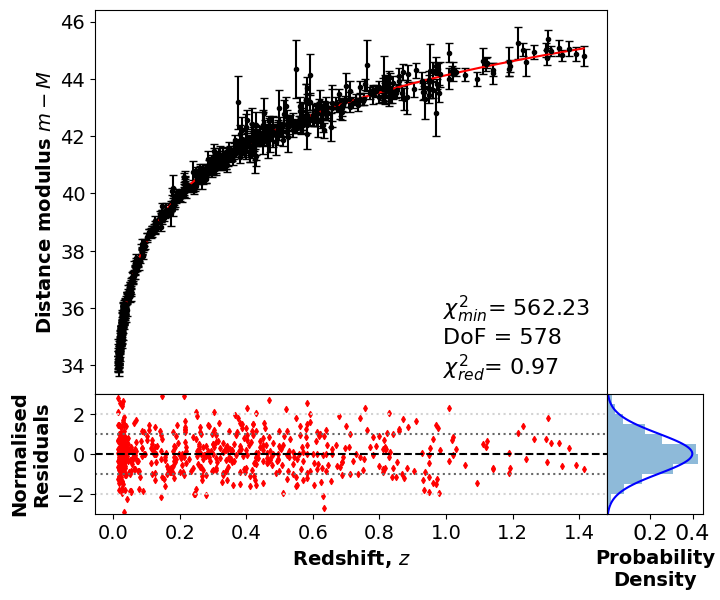

In [177]:
omega_lambda0 = parameters[0]
omega_M0 = parameters[1]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], vals[1]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, omega_M0], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

wCDM model

100%|██████████| 1000/1000 [51:42<00:00,  3.10s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

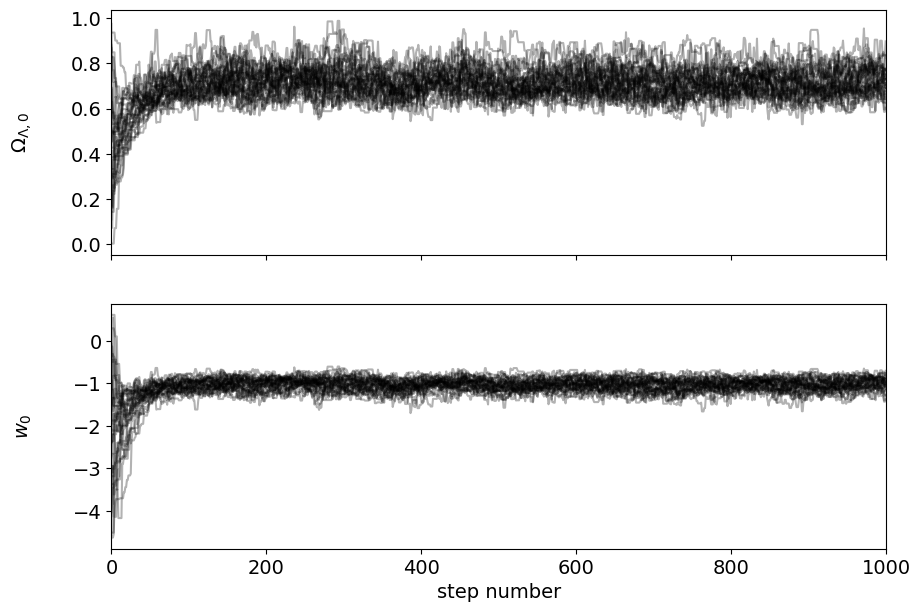

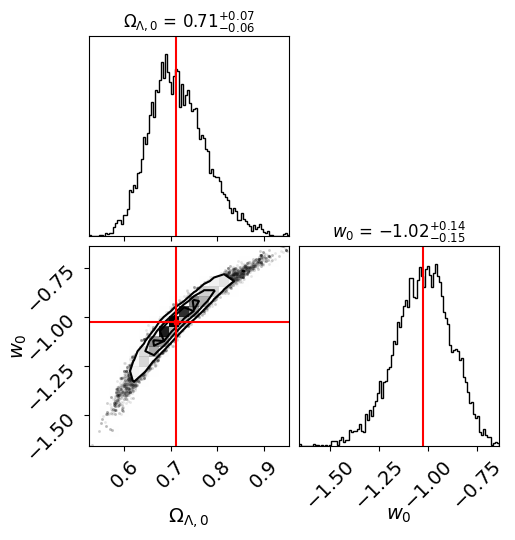

In [178]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0 = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = w_0))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0 = theta
    if 0 < omega_lambda0 < 1 and -5 < w_0 < 1:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6]) * np.random.uniform(low=0, high=1, size=(32, 2)) + np.array([0, 1])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', "$w_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9727516794362899 
 P-value: 0.6728665988043465


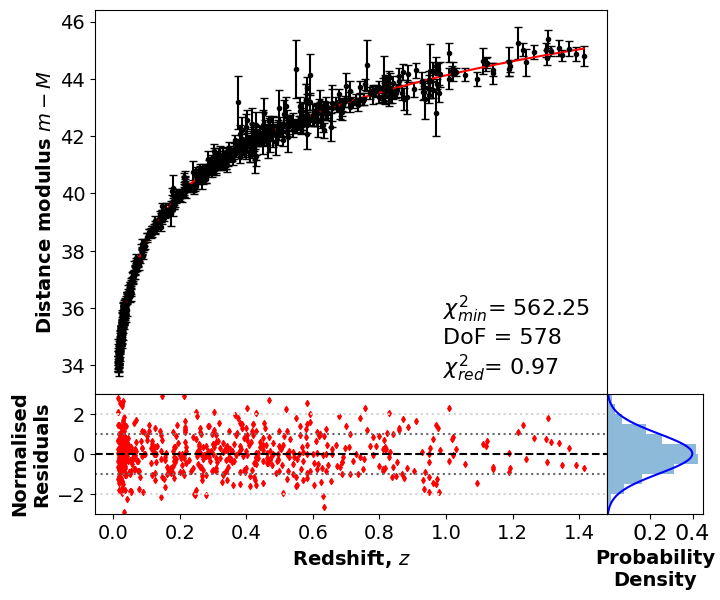

In [179]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model=vals[1]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

Asymptotic model: $w(z) = w_0 + w_a\frac{z}{1+z}$

100%|██████████| 1000/1000 [24:54<00:00,  1.49s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

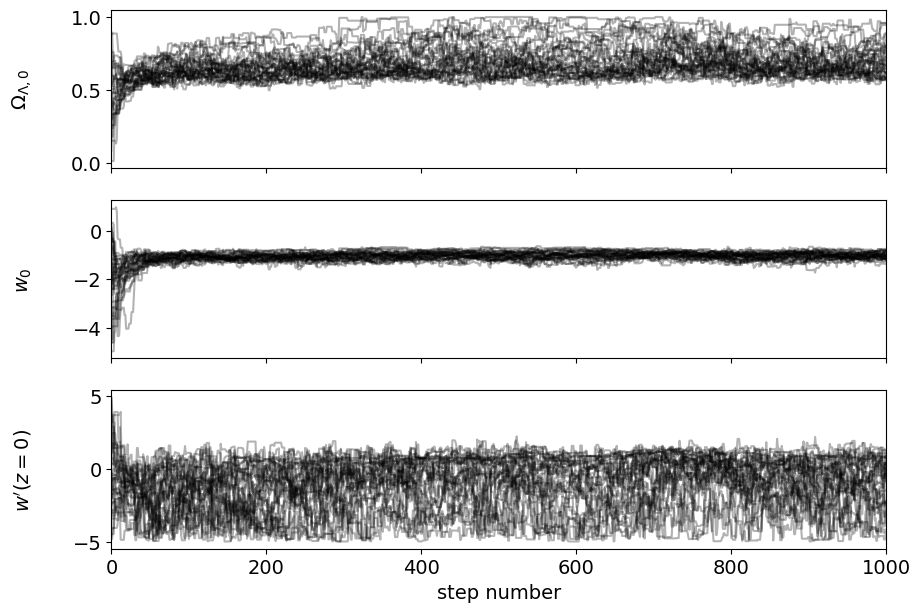

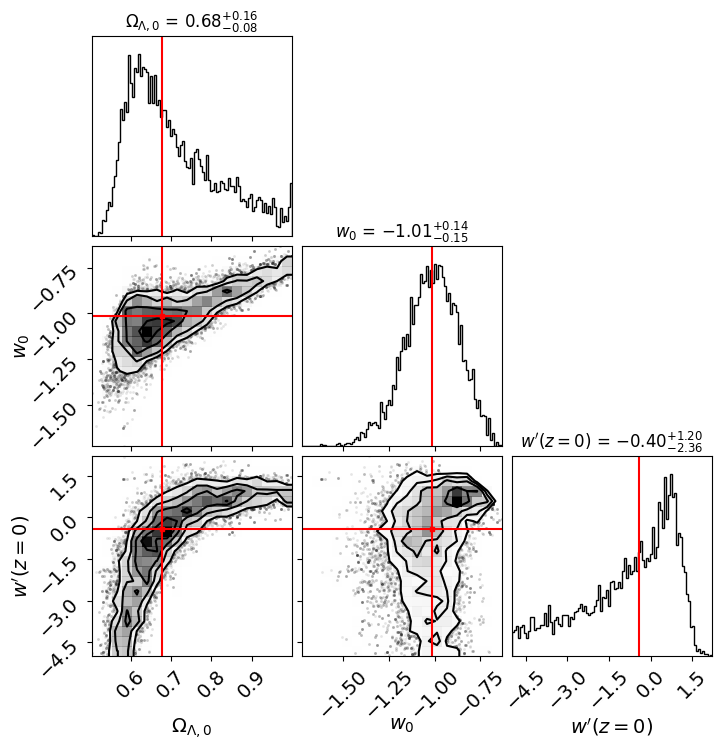

In [180]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = 'asymptotic', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0, w_a = theta
    if 0 < omega_lambda0 < 1 and -5 < w_0 < 1 and -5 < w_a < 5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9779052486474393 
 P-value: 0.6399866109499873


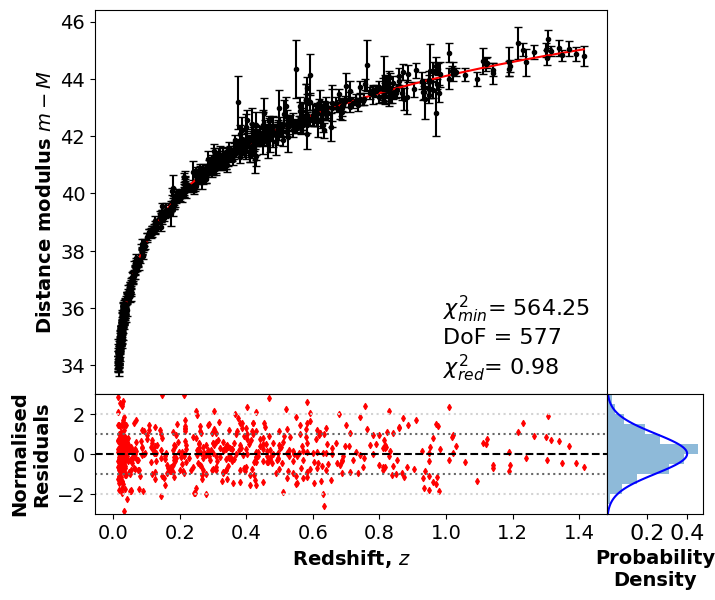

In [181]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
w_a = parameters[2]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model='asymptotic', w_0=vals[1], w_a=vals[2]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

$w(z) = w_0 + w_{z}z$

100%|██████████| 1000/1000 [23:17<00:00,  1.40s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

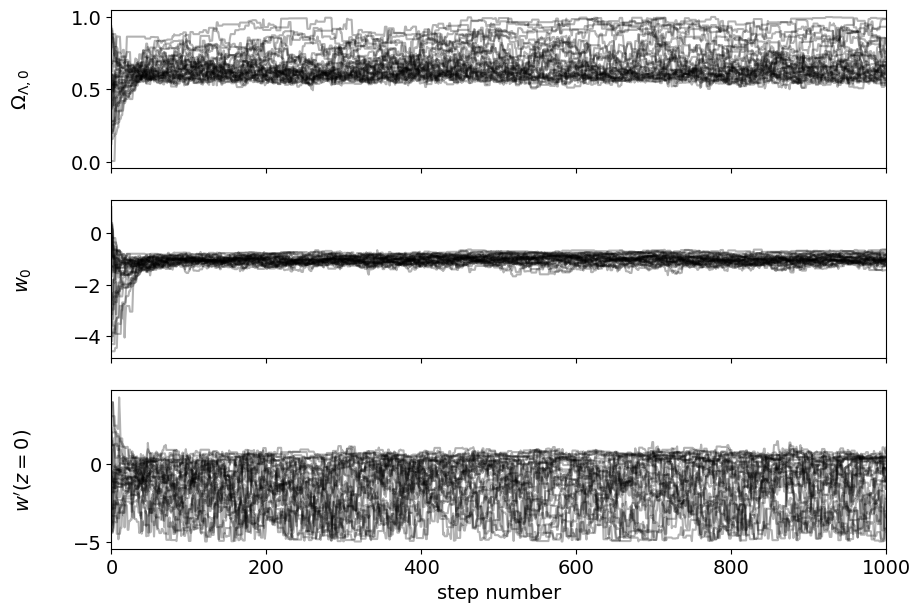

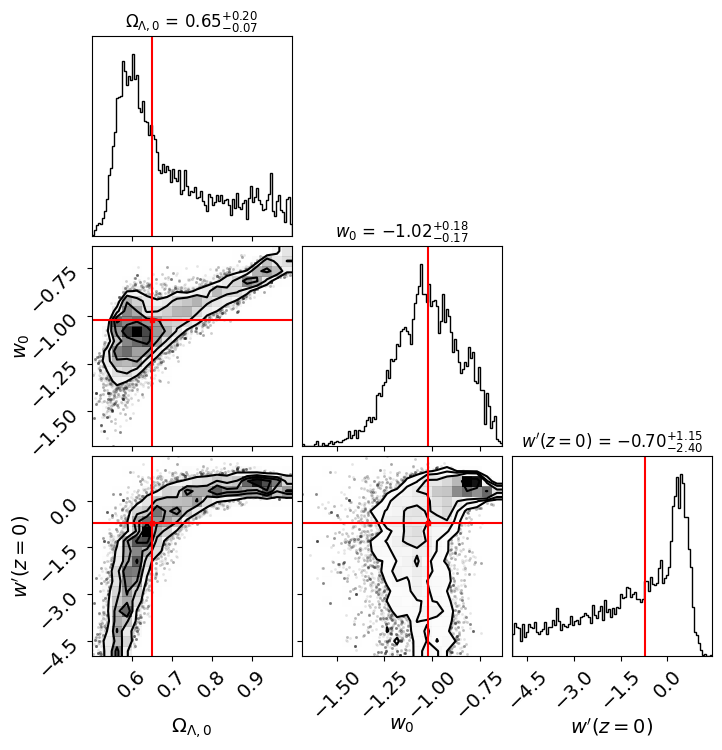

In [182]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = 'linear', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0, w_a = theta
    if 0 < omega_lambda0 < 1 and -5 < w_0 < 1 and -5 < w_a < 5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9807036437599401 
 P-value: 0.6218062756975052


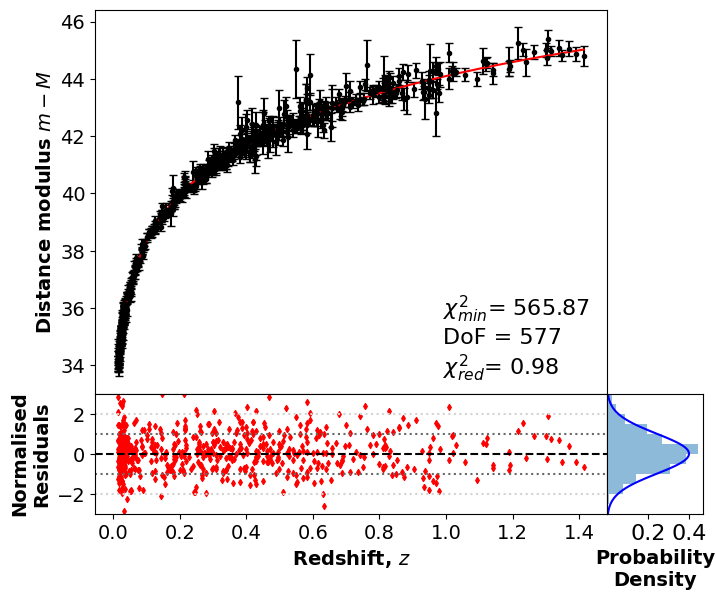

In [183]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
w_a = parameters[2]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model='linear', w_0=vals[1], w_a=vals[2]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

$w(z) = w_0 + w_a\ln(1+z)$ - Logarithmic model

100%|██████████| 1000/1000 [28:54<00:00,  1.73s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

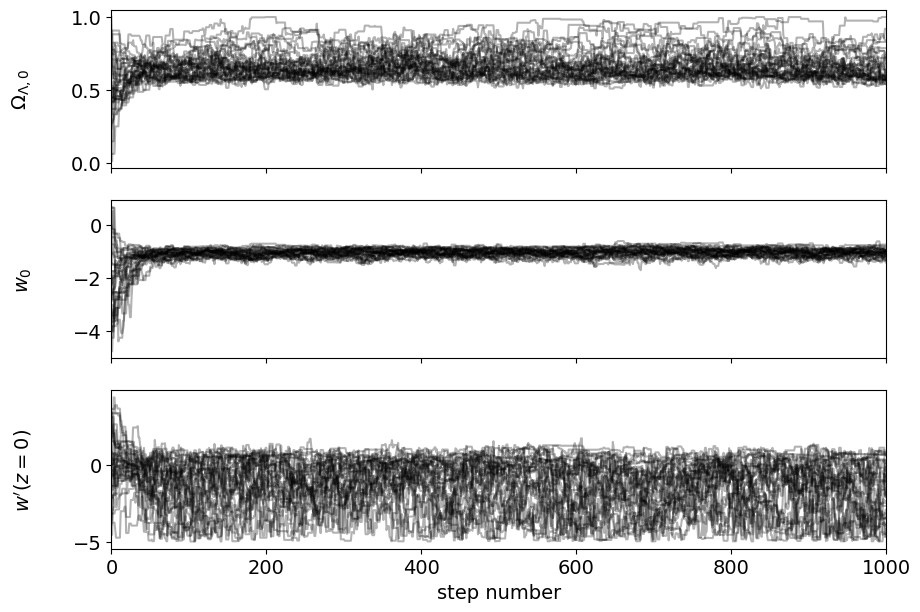

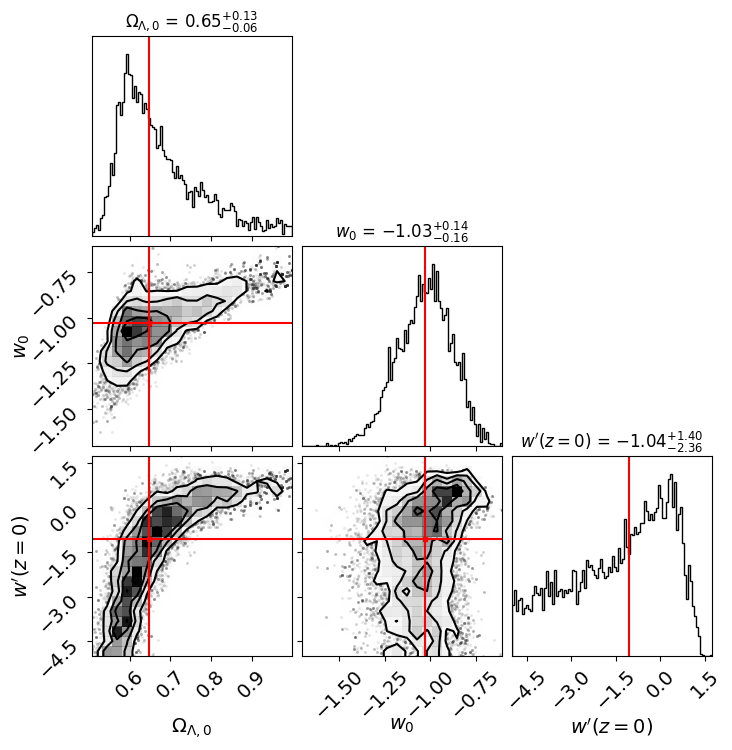

In [184]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = 'logarithmic', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0, w_a = theta
    if 0 < omega_lambda0 < 1 and -5 < w_0 < 1 and -5 < w_a < 5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9773726658341125 
 P-value: 0.6434163837047681


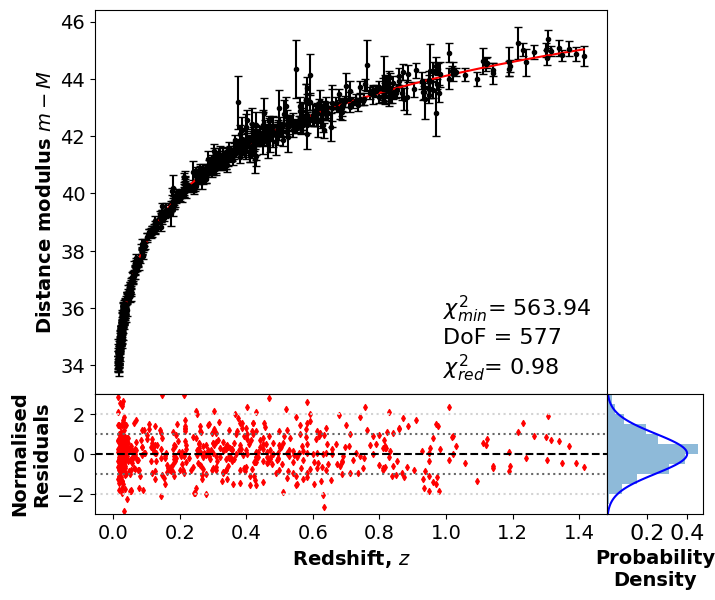

In [185]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
w_a = parameters[2]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model='logarithmic', w_0=vals[1], w_a=vals[2]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

$w(z) = w_0 + w_a \frac{z}{(1+z)^2}$ - p = 2 model

100%|██████████| 1000/1000 [23:07<00:00,  1.39s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

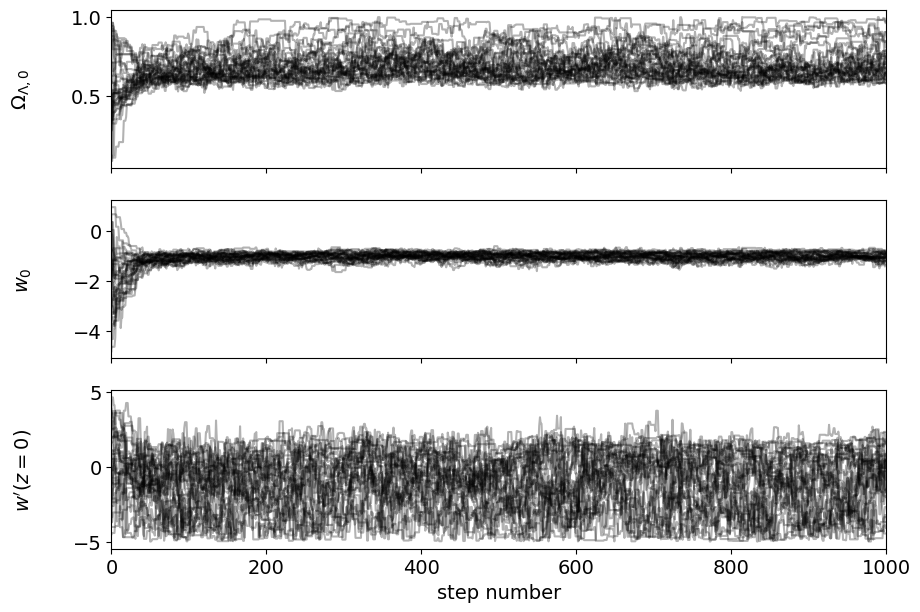

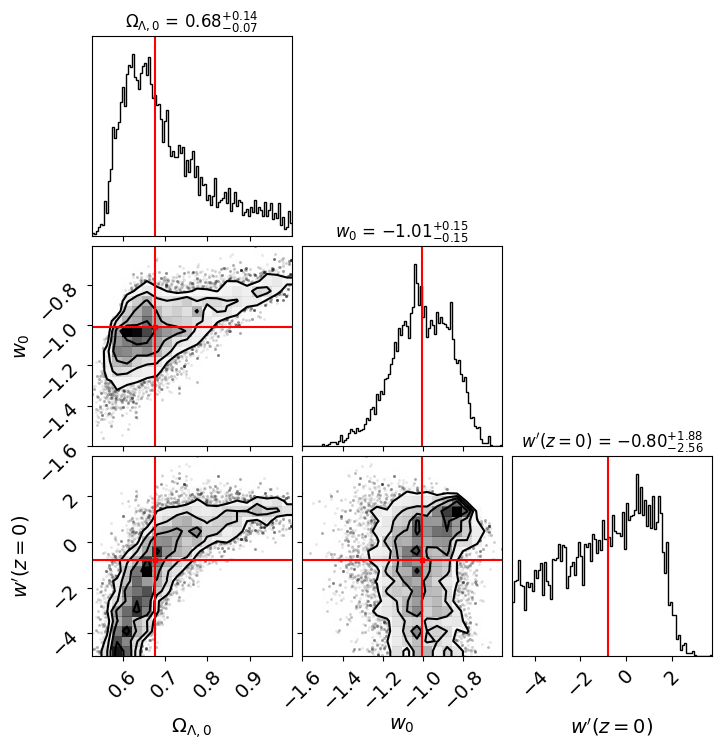

In [186]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = 'p=2', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0, w_a = theta
    if 0 < omega_lambda0 < 1 and -5 < w_0 < 1 and -5 < w_a < 5:
        return 0.0
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$w_0$', "$w'(z=0)$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.975931096437214 
 P-value: 0.652647434788649


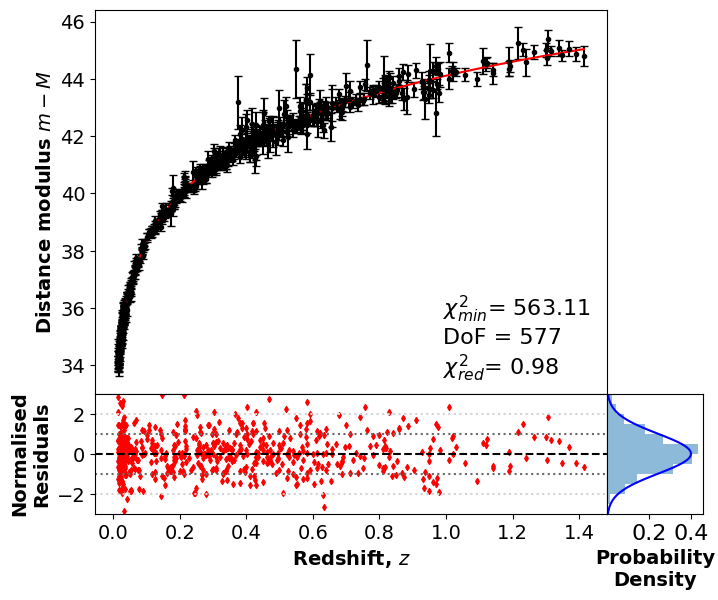

In [187]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
w_a = parameters[2]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model='p=2', w_0=vals[1], w_a=vals[2]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

*WITH PRIORS*

In [188]:
parameter_list.append(['.', '.', '.', '.'])

$\Lambda CDM$ model

100%|██████████| 1000/1000 [13:55<00:00,  1.20it/s]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

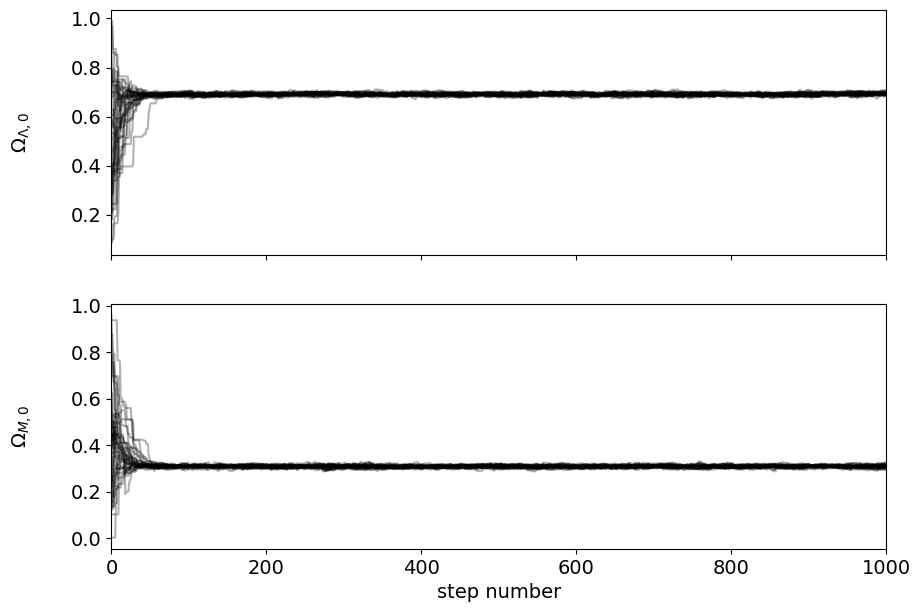

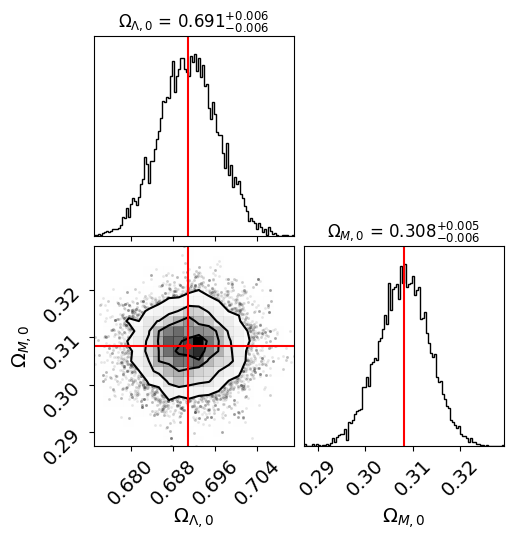

In [189]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, omega_M0 = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, omega_M0, w_model = -1))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, omega_M0 = theta
    if not (0 < omega_lambda0 < 1 and 0 < omega_M0 < 1):
        return -np.inf
    
    # Gaussian prior on omega_lambda0
    lambda_mu = 0.6889     # mean of the Gaussian prior
    lambda_sigma = 1* 0.0056 # standard deviation of the Gaussian prior
    lp1 = -0.5*((omega_lambda0 - lambda_mu)/lambda_sigma)**2

    # Gaussian prior on omega_M0
    M_mu = 0.3111     # mean of the Gaussian prior
    M_sigma = 1* 0.0056 # standard deviation of the Gaussian prior
    lp2 = -0.5*((omega_M0 - M_mu)/M_sigma)**2

    return lp1+lp2

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, 1]) * np.random.uniform(low=0, high=1, size=(32, 2))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$Ω_{M,0}$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.3f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9818047895035494 
 P-value: 0.6146943651983813


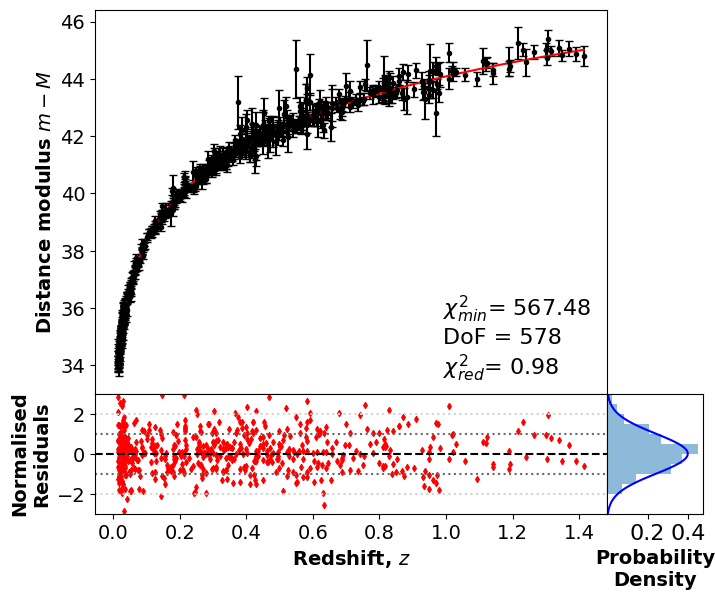

In [190]:
omega_lambda0 = parameters[0]
omega_M0 = parameters[1]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], vals[1]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, omega_M0], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

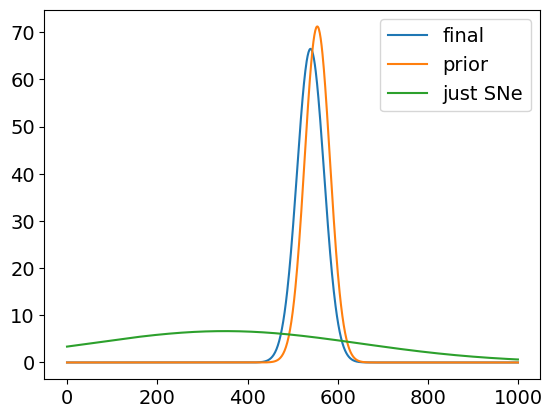

In [191]:
import scipy.stats as stats
plt.plot(stats.norm.pdf(np.linspace(0.2,0.4,1000), 0.308, 0.006), label = 'final')
plt.plot(stats.norm.pdf(np.linspace(0.2,0.4,1000), 0.311, 0.0056), label='prior')
plt.plot(stats.norm.pdf(np.linspace(0.2,0.4,1000), 0.27, 0.06), label='just SNe')

plt.legend()

wCDM model

100%|██████████| 1000/1000 [51:18<00:00,  3.08s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

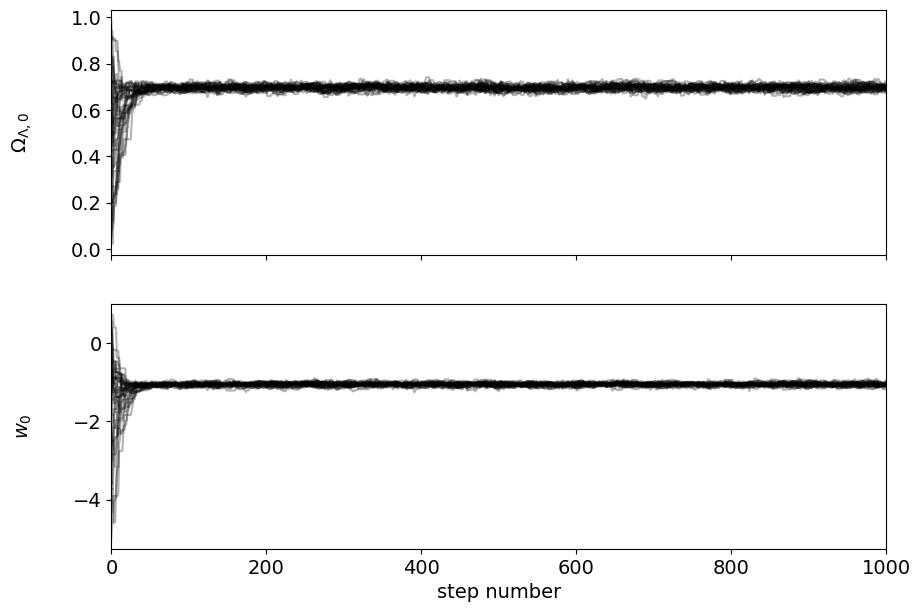

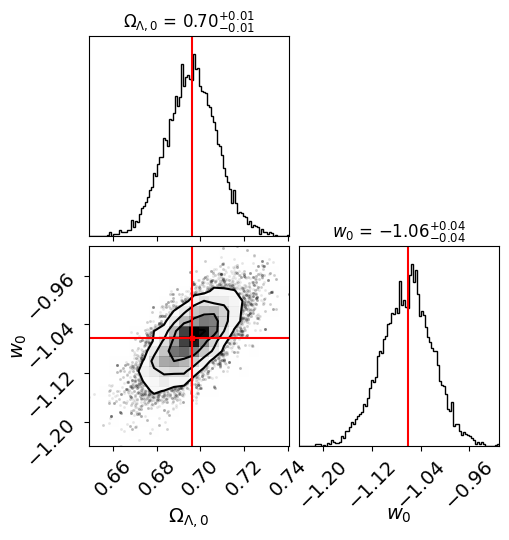

In [192]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0 = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = w_0))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0 = theta
    if not(0 < omega_lambda0 < 1 and -5 < w_0 < 1):
        return -np.inf
    
    lp=0
    # Gaussian prior on omega_lambda0
    lambda_mu = 0.696     # mean of the Gaussian prior
    lambda_sigma = 1* 0.012 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_lambda0 - lambda_mu)/lambda_sigma)**2

    return lp

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6]) * np.random.uniform(low=0, high=1, size=(32, 2)) + np.array([0, 1])
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', "$w_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")

flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9729783202133654 
 P-value: 0.6714493102474675


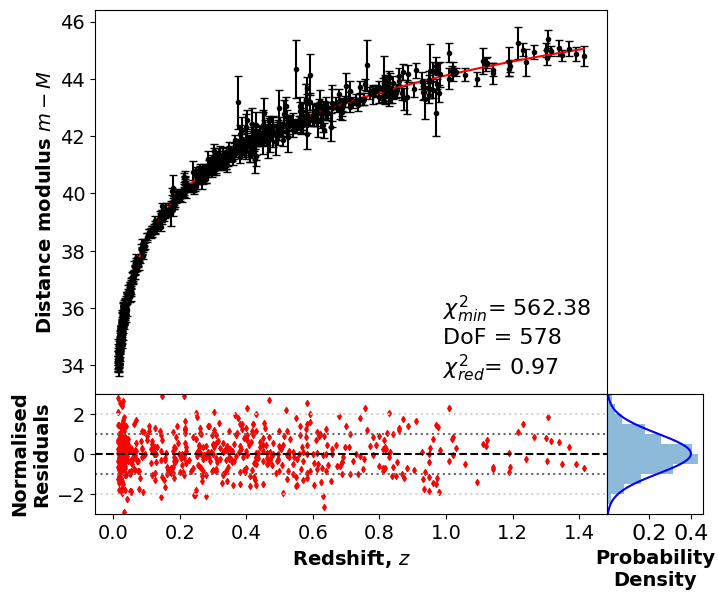

In [193]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model=vals[1]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

Asymptotic model: $w(z) = w_0 + w_a\frac{z}{1+z}$

100%|██████████| 1000/1000 [26:11<00:00,  1.57s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

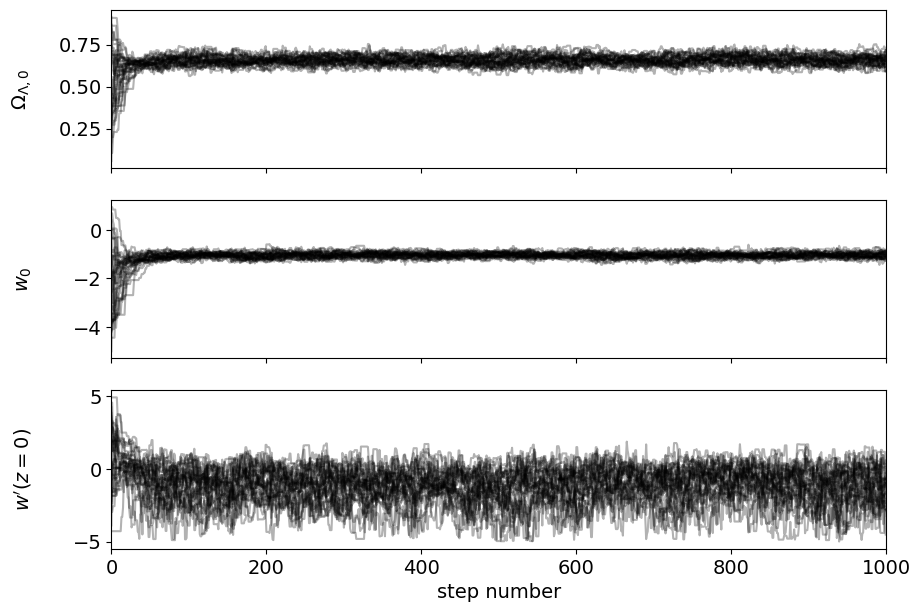

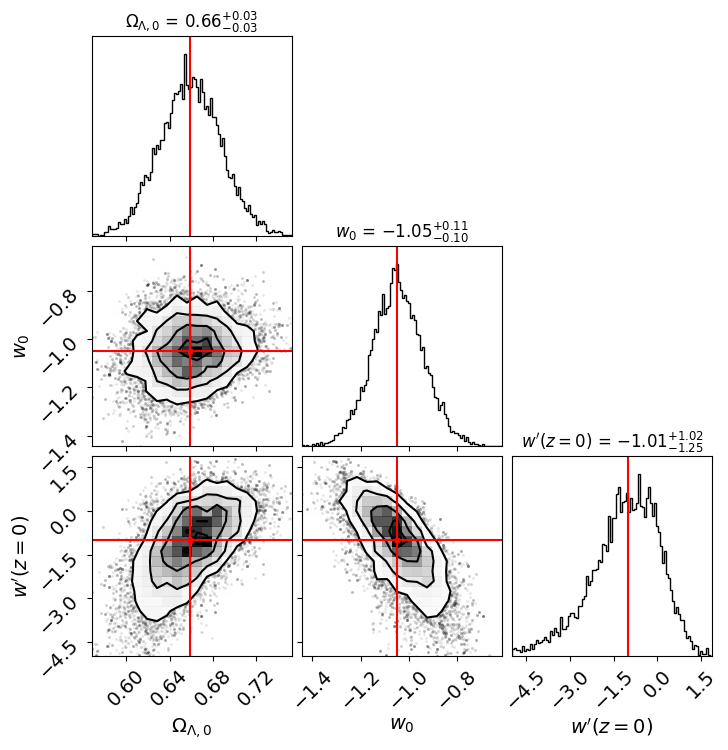

In [194]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = 'asymptotic', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0, w_a = theta
    if not(0 < omega_lambda0 < 1 and -5 < w_0 < 1 and -5 < w_a < 5):
        return -np.inf
    
    lp = 0
    # Gaussian prior on omega_lambda0
    lambda_mu = 1-0.335    # mean of the Gaussian prior
    lambda_sigma = 1* 0.03 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_lambda0 - lambda_mu)/lambda_sigma)**2

    """# Gaussian prior on omega_M0
    M_mu = 0.3111     # mean of the Gaussian prior
    M_sigma = 1* 0.0056 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_M0 - M_mu)/M_sigma)**2"""

    return lp

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5]) #np.array([0.7, -1, 0]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$w_0$', "$w'(z=0)$"]
assert len(labels) == ndim
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
#np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5])
flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9745483135613853 
 P-value: 0.6614262912161575


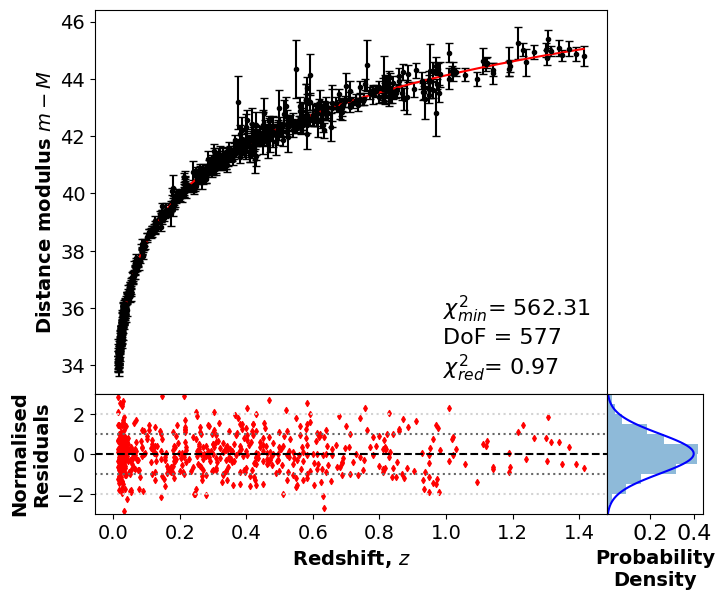

In [195]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
w_a = parameters[2]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model='asymptotic', w_0=vals[1], w_a=vals[2]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

$w(z) = w_0 + w_{z}z$

$w(z) = w_0 + w_a\ln(1+z)$ - Logarithmic model

100%|██████████| 1000/1000 [30:29<00:00,  1.83s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

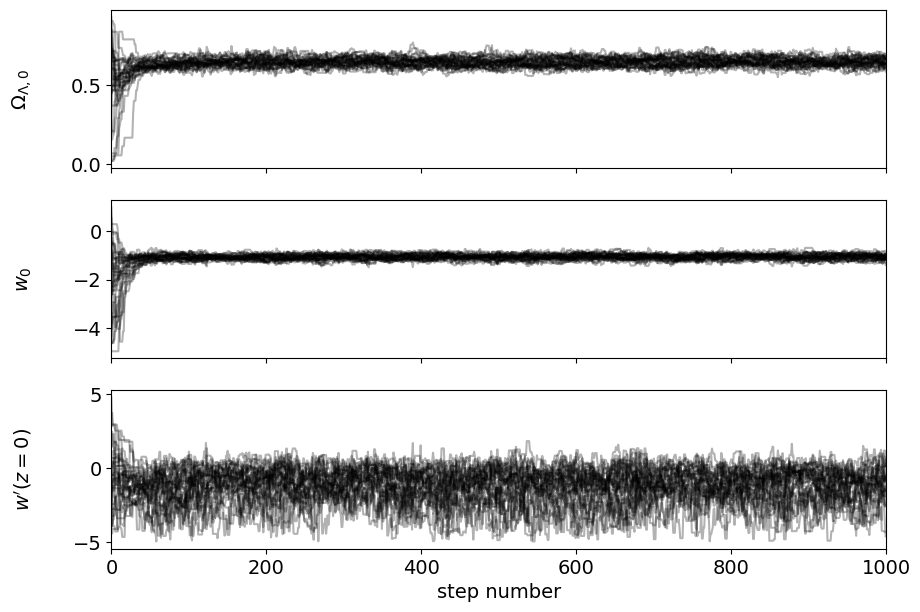

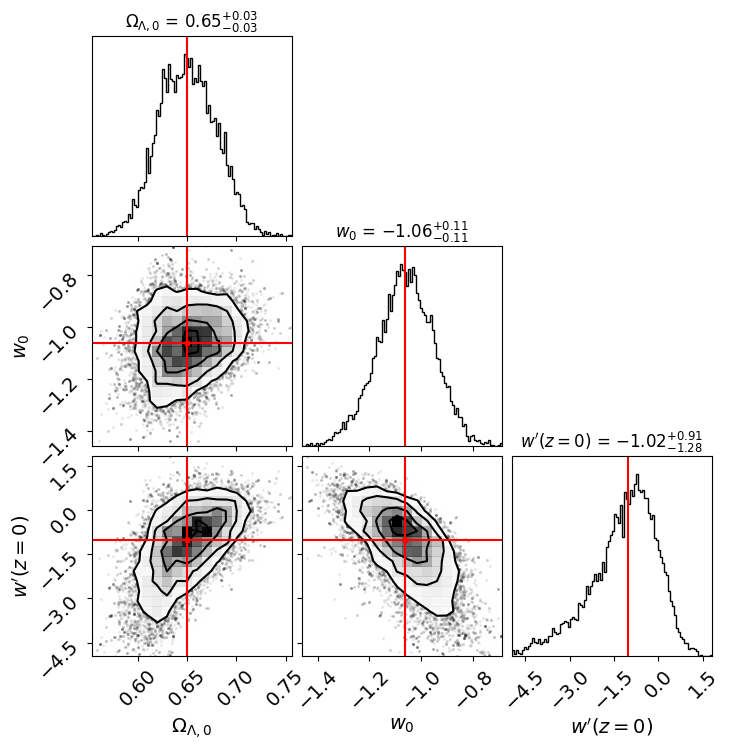

In [196]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = 'logarithmic', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0, w_a = theta
    if not(0 < omega_lambda0 < 1 and -5 < w_0 < 1 and -5 < w_a < 5):
        return -np.inf
    
    lp = 0
    # Gaussian prior on omega_lambda0
    lambda_mu = 1-0.343    # mean of the Gaussian prior
    lambda_sigma = 1* 0.03 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_lambda0 - lambda_mu)/lambda_sigma)**2

    """# Gaussian prior on omega_M0
    M_mu = 0.3111     # mean of the Gaussian prior
    M_sigma = 1* 0.0056 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_M0 - M_mu)/M_sigma)**2"""

    return lp

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5]) #np.array([0.7, -1, 0]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$w_0$', "$w'(z=0)$"]
assert len(labels) == ndim
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
#np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5])
flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9746775611341677 
 P-value: 0.6606090036819825


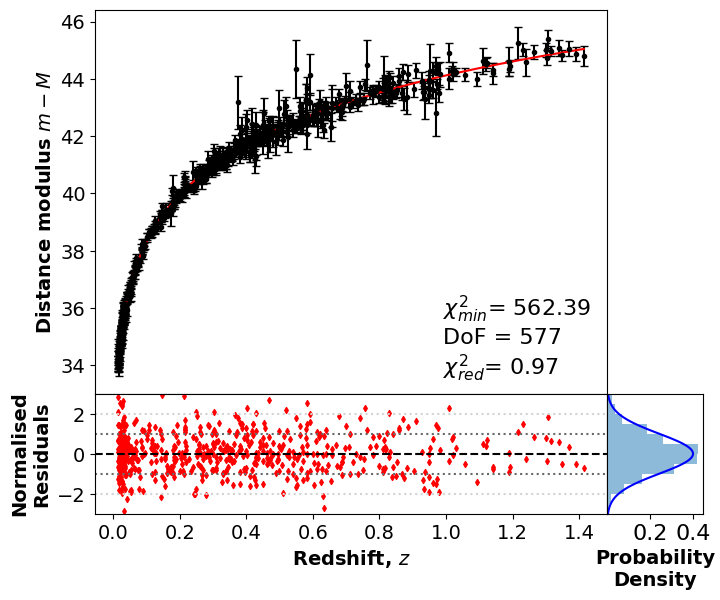

In [197]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
w_a = parameters[2]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model='logarithmic', w_0=vals[1], w_a=vals[2]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

$w(z) = w_0 + w_a \frac{z}{(1+z)^2}$ - p = 2 model

100%|██████████| 1000/1000 [25:28<00:00,  1.53s/it]


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

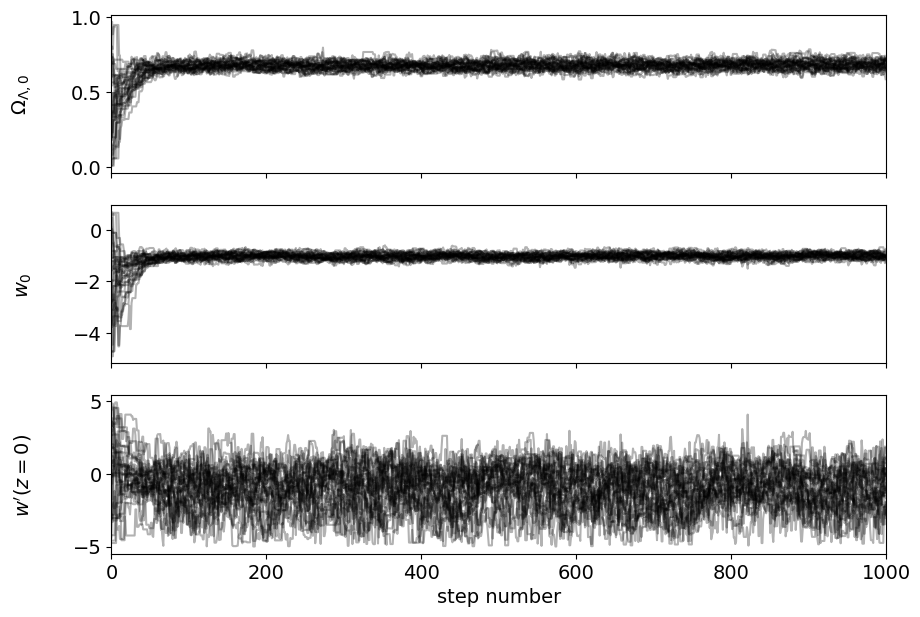

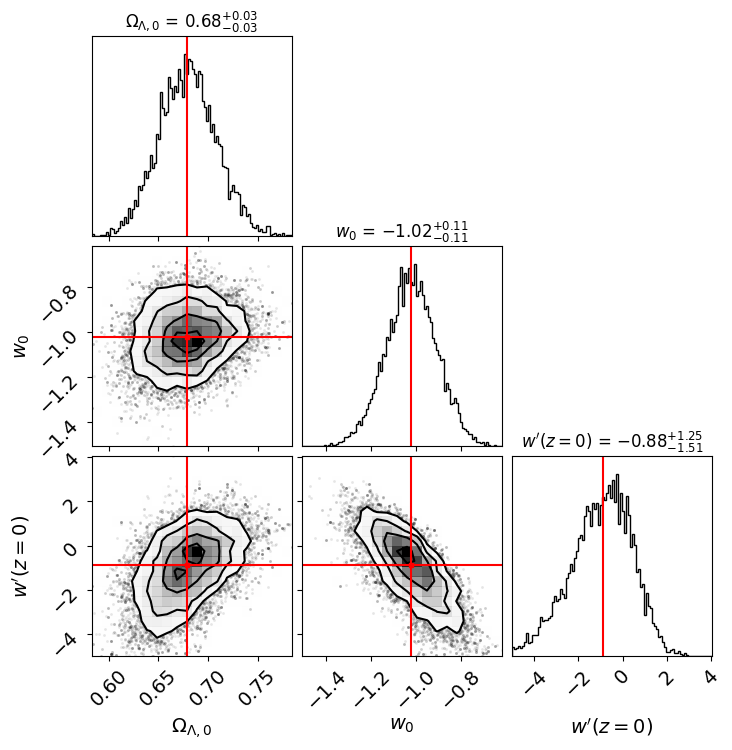

In [198]:
def log_likelihood(theta, x, y, yerr):
    omega_lambda0, w_0, w_a = theta
    model = 5*np.log10((1+x)*functions.get_transverse_comoving_distance(x, H_0, omega_lambda0, 1-omega_lambda0, w_model = 'p=2', w_0 = w_0, w_a = w_a))-5
    return -0.5 * np.sum((y - model) ** 2 / yerr**2)

def log_prior(theta):
    omega_lambda0, w_0, w_a = theta
    if not(0 < omega_lambda0 < 1 and -5 < w_0 < 1 and -5 < w_a < 5):
        return -np.inf
    
    lp = 0
    # Gaussian prior on omega_lambda0
    lambda_mu = 1-0.316    # mean of the Gaussian prior
    lambda_sigma = 1* 0.03 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_lambda0 - lambda_mu)/lambda_sigma)**2

    """# Gaussian prior on omega_M0
    M_mu = 0.3111     # mean of the Gaussian prior
    M_sigma = 1* 0.0056 # standard deviation of the Gaussian prior
    lp += -0.5*((omega_M0 - M_mu)/M_sigma)**2"""

    return lp

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

pos = np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5]) #np.array([0.7, -1, 0]) + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(xval, yval, yerr))
sampler.run_mcmc(pos, no_steps, progress=True)

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['$Ω_{Λ,0}$', '$w_0$', "$w'(z=0)$"]
assert len(labels) == ndim
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
#np.array([1, -6, -10]) * np.random.uniform(low=0, high=1, size=(32, 3)) + np.array([0, 1, 5])
flat_samples = sampler.get_chain(discard=no_to_discard, flat=True)

fig = corner.corner(
    flat_samples, labels=labels, truths=[np.percentile(flat_samples[:, i], [16, 50, 84])[1] for i in range(0, ndim)],
truth_color = 'red', hist_bin_factor = 5, show_titles = True, title_fmt='.2f', title_kwargs={'fontsize': 12})

parameters = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{3} = "+"${{{0:.3f}}}_{{-{1:.3f}}}^{{{2:.3f}}}$"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    parameters.append(mcmc[1])
    display(Math(txt))

parameter_list.append(parameters)

Reduced chi-squared: 0.9744503508567527 
 P-value: 0.6620452935423616


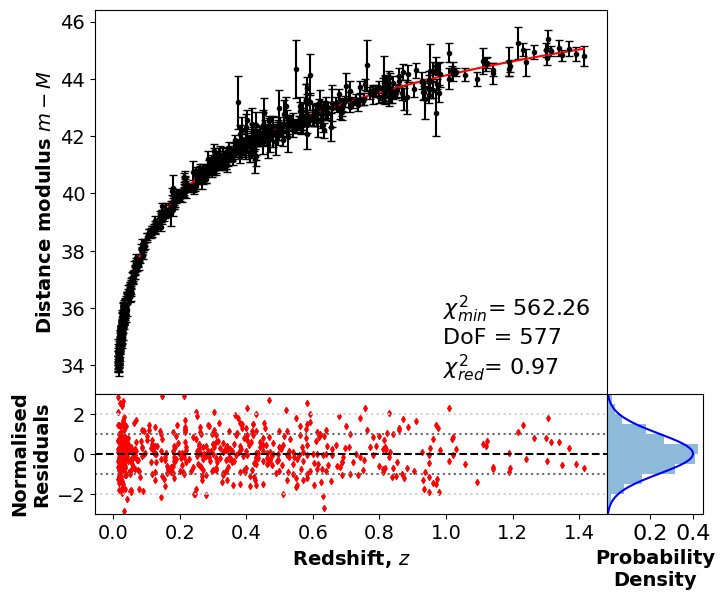

In [199]:
omega_lambda0 = parameters[0]
w_0 = parameters[1]
w_a = parameters[2]
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], 1-vals[0], w_model='p=2', w_0=vals[1], w_a=vals[2]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - len(parameters)
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *parameters), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()

In [200]:
print(parameter_list)

[[0.7224232175961406, 0.2780798747056896], [0.710917128539065, -1.0246215299217583], [0.6782773961135693, -1.0134491935597802, -0.40448116516876587], [0.6499518815103729, -1.0211766120558672, -0.7046499707338151], [0.6463689497632803, -1.025973779905256, -1.0410282569438354], [0.6762503634349976, -1.007514139483304, -0.802629394919142], ['.', '.', '.', '.'], [0.6909154077449872, 0.3081340689389044], [0.6960172572871467, -1.061783705937611], [0.6590862675928477, -1.0494931254373305, -1.0106600330260562], [0.6491607201982158, -1.0614643561871584, -1.0188902400808266], [0.6793287437642686, -1.0220326724627147, -0.8779780752299853]]


Reduced chi-squared: 0.9768013785411311 
 P-value: 0.6469496821750799


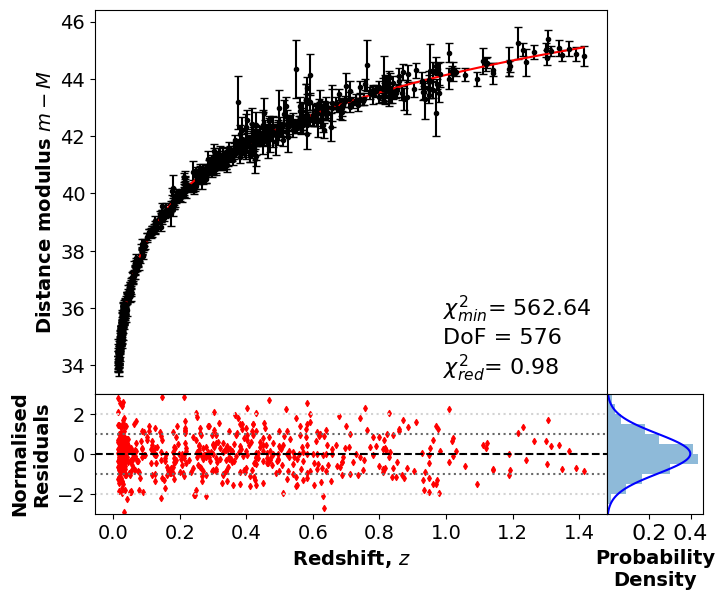

In [201]:
omega_lambda0 = 0.44
omega_M0 = 0.22
w_0 = -1.5
w_a = 0.6
"""print(xval)
print(np.append(xval, 2))
xval = np.append(xval, 2)
yval = np.append(yval, 46)
yerr = np.append(yerr, 0.1)"""
#order arrays in ascending order
order = np.argsort(xval)
xval = xval[order]; yval = yval[order]; yerr = yerr[order]
#the model function that we're fitting to the dataset.
def model_funct(xs, *vals):
    return 5*np.log10((1+xs)*functions.get_transverse_comoving_distance(xs, H_0, vals[0], vals[1], w_model='asymptotic', w_0=vals[2], w_a=vals[3]))-5

norm_residuals = functions.get_norm_residuals([omega_lambda0, omega_M0, w_0, w_a], model_funct, xval, yval, yerr)
chisq_min = np.sum(norm_residuals**2)
deg_freedom = len(xval) - 4
chisq_reduced = chisq_min/deg_freedom
P = scipy.stats.chi2.sf(chisq_min, deg_freedom)
print("Reduced chi-squared:", chisq_reduced, "\n P-value:", P)

#plotting final graph with data overlaid by best-fit curve, with normalised residuals and their probability density subplots.
plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(xval, yval, yerr=yerr, marker='o', linestyle='None', color = 'black', capsize = 3)
smooth_xval = np.linspace(xval[0], xval[-1], 1001)
plt.plot(smooth_xval, model_funct(smooth_xval, *[omega_lambda0, omega_M0, w_0, w_a]), color = 'red')
plt.annotate('$χ^2_{min}$' + f'= {np.round(chisq_min, 2)}' + '\n' 
            + f'DoF = {deg_freedom}' + '\n'
            + '$χ^2_{red}$' + f'= {np.round(chisq_reduced, 2)}' ,
#                 + f'P = {np.round(P, 3)}', 
            xycoords = 'axes fraction', xy = (0.68, 0.05), backgroundcolor = 'white', fontsize = 16)
plt.ylabel("Distance modulus $m - M$", weight = 'bold')
#plt.ylim(14.1, 19.7)
plt.gca().set_xticks([])

#normalised residual plot
plt.figure(1).add_axes((0,-0.25,0.8,0.25))
plt.scatter(xval, norm_residuals, color='red', marker = 'd')
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel("Redshift, $z$", weight = 'bold')

#normalised residual distribution histogram.
plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.hist(norm_residuals, bins=np.arange(-100, 100, 0.5), alpha = 0.5, density = True, orientation = 'horizontal')
plt.ylim(3, -3)
plt.xticks([0.2,0.4], fontsize = 16)
mu = 0; variance = 1
sigma = np.sqrt(variance)
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(scipy.stats.norm.pdf(y, mu, sigma), y, color = 'blue')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

plt.show()